# **Parameter Optimisation for TSPMe model** 

This notebook is created to provide an example for ```data_fit``` optimisation problem. Selected PyBaMM parameters are optimised in this notebook.
This can also be found in `scripts/multiple_variable_fit.py` as Python function. The workflow is as follows:


In [1]:
!git clone https://github.com/paramm-team/pybamm-param.git
!pip install pybamm
%cd pybamm-param
# import required scripts to process experimental data
import process_experimental_data as prepos
from set_parameters import (
    set_thermal_parameters,
    set_experiment_parameters,
    set_ambient_temperature,
)
import pybamm
import numpy as np
import pbparam
import pandas as pd

Cloning into 'pybamm-param'...
Updating files:  28% (64/221)
Updating files:  29% (65/221)
Updating files:  30% (67/221)
Updating files:  31% (69/221)
Updating files:  32% (71/221)
Updating files:  33% (73/221)
Updating files:  34% (76/221)
Updating files:  35% (78/221)
Updating files:  36% (80/221)
Updating files:  37% (82/221)
Updating files:  38% (84/221)
Updating files:  39% (87/221)
Updating files:  40% (89/221)
Updating files:  41% (91/221)
Updating files:  42% (93/221)
Updating files:  43% (96/221)
Updating files:  44% (98/221)
Updating files:  45% (100/221)
Updating files:  46% (102/221)
Updating files:  47% (104/221)
Updating files:  48% (107/221)
Updating files:  49% (109/221)
Updating files:  50% (111/221)
Updating files:  51% (113/221)
Updating files:  52% (115/221)
Updating files:  53% (118/221)
Updating files:  54% (120/221)
Updating files:  55% (122/221)
Updating files:  56% (124/221)
Updating files:  57% (126/221)
Updating files:  58% (129/221)
Updating files:  59% (131

c:\Users\Sogut2_M\Desktop\GitHub\pybamm-param\examples\notebooks\pybamm-param


Initially, data parameters are defined as below:

In [2]:
temperature = 25  # in degC, valid values: 0, 10, 25
crate = 1  # valid values: 0.5, 1, 2
cell_selected = ["789"] # Multiple cells can be selected. Cell '791' should be avoided due to being faulty.

Then, it should be processed to get suitable format for PyBaMM. Please note that experimental data is stored in Pandas DataFrame in this example.

In [3]:
dataset = prepos.import_thermal_data(crate, temperature)
# empty dictionary is created for stroring experimental data.
data_conc = {
    "Time [s]": [],
    "Terminal voltage [V]": [],
    "X-averaged cell temperature [degC]": [],
}
# Time, Voltage and Temperature is imported from the files.
for cell, data in dataset.items():
    if cell in cell_selected:
        idx_start, idx_end = prepos.get_idxs(data, crate * 5, 5 / 3)
        if len(idx_end) == 1:
            idx_end = np.append(idx_end, len(data["Time [s]"]))
        data_conc["Time [s]"] = np.append(
            data_conc["Time [s]"],
            data["Time [s]"][idx_start[0] : idx_end[1]]
            - data["Time [s]"][idx_start[0]],
        )
        data_conc["Terminal voltage [V]"] = np.append(
            data_conc["Terminal voltage [V]"],
            data["Voltage [V]"][idx_start[0] : idx_end[1]],
        )
        data_conc["X-averaged cell temperature [degC]"] = np.append(
            data_conc["X-averaged cell temperature [degC]"],
            data["Temp Cell [degC]"][idx_start[0] : idx_end[1]],
        )
data_conc = pd.DataFrame(data_conc)
# Temperature is converted from degC to K.
data_conc["X-averaged cell temperature [degC]"] = (
    data_conc["X-averaged cell temperature [degC]"] + 273.15
)
data_conc = data_conc.rename(
    columns={"X-averaged cell temperature [degC]": "X-averaged cell temperature [K]"}
)

In order to optimise reaction coefficient, Negative Electrode Exchange-Current Density is tuned by ```j0_neg``` function:

In [4]:
def j0_neg(c_e, c_s_surf, c_s_max, T):
    """
    This function has been copied from the Chen2020 parameter set:
    pybamm/input/parameters/lithium_ion/negative_electrodes/graphite_Chen2020
    /graphite_LGM50_electrolyte_exchange_current_density_Chen2020.py
    Similar could be done for the positive exchange current density
    """
    m_ref = pybamm.Parameter("Negative electrode reaction coefficient")
    E_r = 3500
    arrhenius = pybamm.exp(E_r / pybamm.constants.R * (1 / 298.15 - 1 / T))
    return (
        m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
    )

PyBaMM model to be used for parameter optimisation needs to be defined:

In [5]:
model = pybamm.lithium_ion.SPMe(
    options={
        "thermal": "lumped",
        "dimensionality": 0,
        "cell geometry": "arbitrary",
        "electrolyte conductivity": "integrated",
    },
    name="TSPMe",
)

Rest of the PyBaMM simulation requirements and initial parameters defined here:

In [6]:
param_default = pybamm.ParameterValues("Chen2020") # Initial parameters to be used.
param = set_thermal_parameters(param_default, 16, 2.32e6, temperature)
param = set_experiment_parameters(param, crate, temperature)
param = set_ambient_temperature(param, crate, temperature)

# Parameters can be changed individually in here:
param.update(
    {
        "Negative electrode exchange-current density [A.m-2]": j0_neg,
        "Negative electrode reaction coefficient": 6.48e-7
    },
    check_already_exists=False,
)
experiment = pybamm.Experiment(
    [
        "Discharge at {}C until 2.5 V (5 seconds period)".format(crate),
        "Rest for 2 hours",
    ],
    period="30 seconds",
)
simulation = pybamm.Simulation(
    model,
    parameter_values=param,
    experiment=experiment,
)

PyBaMM-param needs a dictionary for parameters to be optimised in ```{"parameter name": (initial guess, (lower bound, upper bound))}```

In [7]:
param_optimised = {
    "Negative electrode diffusivity [m2.s-1]": (5e-14, (2.06e-16, 2.06e-12)),
    "Negative electrode reaction coefficient": (
        6.48e-7,
        (2.18589831e-9, 2.18589831e-5),
    ),
    "Total heat transfer coefficient [W.m-2.K-1]": (20, (0.1, 1000)),
    (
        "Positive current collector specific heat capacity [J.kg-1.K-1]",
        "Negative current collector specific heat capacity [J.kg-1.K-1]",
        "Negative electrode specific heat capacity [J.kg-1.K-1]",
        "Separator specific heat capacity [J.kg-1.K-1]",
        "Positive electrode specific heat capacity [J.kg-1.K-1]",
    ): (2.85e3, (2.85, 2.85e6)),
}

Which variables will be considered should be provided in a list:

In [8]:
variables_optimised = ["Terminal voltage [V]", "X-averaged cell temperature [K]"]
cost_function = pbparam.RMSE()
opt = pbparam.DataFit(simulation, data_conc, param_optimised, variables_optimised, cost_function)

Firstly, cost funtion for optimisation algorithm should be defined. Then, optimisation problem with PyBaMM simulation, experimental data, dictionary of parameters with initial guesses and bounds, variables to be optimised and cost function should be passed.

In [9]:
cost_function = pbparam.RMSE()
# Since this is a parameter optimisation with fitting data into experimental data, optimisation problem is DataFit.
opt = pbparam.DataFit(simulation, data_conc, param_optimised, variables_optimised, cost_function)

Then, Optimisation method should be defined in this step. DiferentialEvolution(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html) or ScipyMinimize(https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

can be used to minimise cost function. For faster results, ScipyMinimize with ```"Nelder-Mead"``` method can be used. However, ScipyDifferentialEvolution is more robust and has provided lower value for most of the cases. 

In [10]:
# optimiser = pbparam.ScipyDifferentialEvolution(
#     extra_options={"workers": 4, "polish": True, "updating": "deferred", "disp": True}
# )
optimiser = pbparam.ScipyMinimize(method="Nelder-Mead", extra_options={"tol": 1e-6})

After providing everything for optimisation algorithm, it can be performed using``` optimise(optimisation_problem)```

In [11]:
result = optimiser.optimise(opt)
# optimised values of parameters and function values can be printed as below.
print(result.x, result.fun)

functools.partial(<function objective_function_full at 0x000002298784F820>, <pbparam.optimisation_problems.data_fit.DataFit object at 0x00000229893F2CD0>)
[1. 1. 1. 1.]
[(0.0041199999999999995, 41.2), (0.0033732998611111114, 33.732998611111114), (0.005, 50.0), (0.001, 1000.0)]


TypeError: j0_neg() missing 1 required positional argument: 'T'

```plot()``` function can be used to present result graphically.

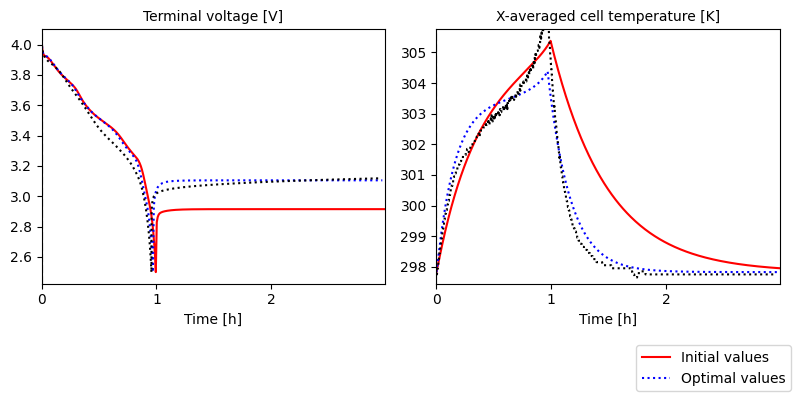

In [ ]:
result.plot()